This notebook is a version of the following:

https://github.com/lmoroney/dlaicourse/blob/master/Course%201%20-%20Part%208%20-%20Lesson%204%20-%20Notebook.ipynb


# Import and structure data

The magic function `%%capture`eliminates the output to not overcrowd the screen

In [ ]:
%%capture
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

To extract zip files we first define a variable with the location of the `zip`file, then we create and object of the class `zipfile.Zipfile` and finally we use the method `extractall('< destination_path >')`

In [ ]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

Now we have the following structure in `tmp` folder:
- `tmp`
  - `horse-or-human`
    - `horses` (Directory with x photos of horses)
    - `humans` (Directory with y phoros of humans)
  - `validation-horse-or-human`
    - `horses` (Same)
    - `humans` (Same)
  

Then we define a variable for each directory (**horse**, **human**) for *train* and *validation*

In [ ]:
import os
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
train_human_dir = os.path.join('/tmp/horse-or-human/humans')
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

Then we get the names of the images for each folder. For that we'll be using the `os.listdir()`function

In [ ]:
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

validation_horse_names = os.listdir(validation_horse_dir)
validation_human_names = os.listdir(validation_human_dir)

In [ ]:
print(f'There are {len(train_horse_names)} horse images, {len(train_human_names)} human images in the training set')
print(f'There are {len(validation_horse_names)} horse images, {len(validation_human_names)} human images in the validation set')

There are 500 horse images, 527 human images in the training set
There are 128 horse images, 128 human images in the validation set


## Building a model from scratch

To build the model we will be following the next steps:
1. **Define the model**. We will be using a `sequential`model which will go layer by layer. We will add 3 `conv2d`+`maxpooling` layers.
  *   `Conv2d` with 16->32->64 **Note that they go from smaller to greater** filters of (3,3) each. The first layer takes the input shape (150x150x3). Remainder: the input_shape is the **desired** size of the images, not the actual one. As activation function we'll be using '*relu*'(avoid negatives).

      *Every output shape of convolutional layers is reduced a bit due to padding*
  *   `MaxPooling2D` (2,2) with no activation function.
  * `Flatten()` layer to feed the Densely connected layers (Dense means all neurons connected to all)
  * `Dense` layer with 512 units and '*relu*'
  * `Dense` layer with 1 unit and '*Sigmoid*' activation (Binary output)
  ***
2. **Compile the model**. For that we should choose 3 hyperparameters: `loss`, `accuracy` and `metrics`.
  * `loss`: train the model with `binary_crossentropy` and final activation is a Sigmoid
  * `optimizer`: `RMSprop` with learning rate (lr) of 0.001 which will be tunned automatically through the epochs?
  * `metrics`: *['accuracy']* It recognizes the proportion that the algorithm is right, no matter TP or TN. The formula is (TP+TN)/(TP+TN+FP+FN)
  ***
3. **Data preprocessing**: We will build two different generators (one for training, other for validation).
  * Training: `target_size`=(150,150) as indicated in the model definition input_shape, a `batch_size` of 128 (4 chunks 500/128 = 3.9) and a `class_mode` binary
  * Validation: same target_size(150x150) `batch_size` of 32 (4 chunks 128/32=4) and same `class_mode`
  ***
4. **Training** same as saying **fit** the model.
  * As data we input the `train_generator` object
  * For every epoch we'll repeat the process 8 times `steps_per_epoch`=8
  * `epoch`=15
  * In this case it is also included the validation data through the `validation_data` argument = `validator_generator` and `validation_steps` = 8







In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

`ImageGenerator` reads images from subdirectories, and automatically label them from the name of that subdirectory

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 11s 851ms/step - loss: 5.7178 - accuracy: 0.5093 - val_loss: 0.4390 - val_accuracy: 0.8320
Epoch 2/15
8/8 [==============================] - 6s 756ms/step - loss: 0.6343 - accuracy: 0.6786 - val_loss: 0.4844 - val_accuracy: 0.8008
Epoch 3/15
8/8 [==============================] - 6s 766ms/step - loss: 0.3398 - accuracy: 0.8549 - val_loss: 0.6798 - val_accuracy: 0.8438
Epoch 4/15
8/8 [==============================] - 6s 772ms/step - loss: 0.2011 - accuracy: 0.9138 - val_loss: 0.4478 - val_accuracy: 0.8359
Epoch 5/15
8/8 [==============================] - 6s 778ms/step - loss: 0.2982 - accuracy: 0.9272 - val_loss: 0.7260 - val_accuracy: 0.8242
Epoch 6/15
8/8 [==============================] - 7s 851ms/step - loss: 0.0896 - accuracy: 0.9730 - val_loss: 0.8107 - val_accuracy: 0.8281
Epoch 7/15
8/8 [==============================] - 6s 799ms/step - loss: 0.0509 - accuracy: 0.9877 - val_loss: 1.0647 - val_accuracy: 0.8594
Epoch 8/15
8/8 [===

The following code will allow to upload an image and then recognize wether it is a human or a horse. For that we run the function `files.upload()`. As it can be uploaded one or more images, we establish a for that loops over the keys in the dictionary of images it is created.

Then we create the full path concatting /content/ to the key of the image.

The module `keras.preprocessing.image` has the function `load_img()` which also takes the *target_size* as argument (150, 150). Then we convert the image to array also with a function of the same module `image.img_to_array()`, then we expand the dimensions:

```
x = np.array([1, 2])
x.shape
>>> (2,)
y = np.expand_dims(x, axis=0)
y
>>> array([[1, 2]])
y.shape
>>> (1, 2)
```
Finally `np.vstack` concats the content in vertical:


```
a = np.array([1, 2, 3])
b = np.array([2, 3, 4])
np.vstack((a,b))
>>> array([[1, 2, 3],
           [2, 3, 4]]
```
The last step is creating a variable with the result of applying the model (`model.predict`) 




In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

## Visualize intermediate steps and outputs
The idea is to visualize the result of the `conv` and `maxpooling` output layers

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


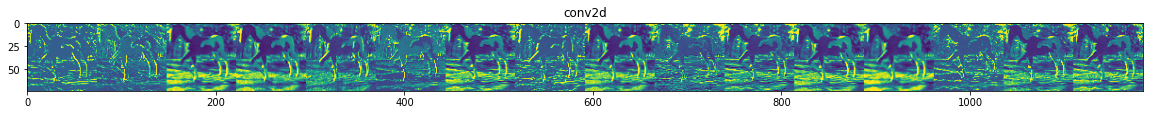

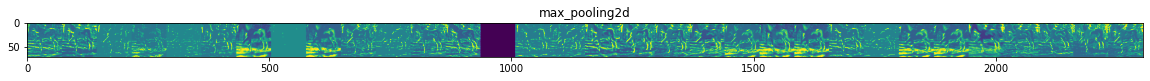

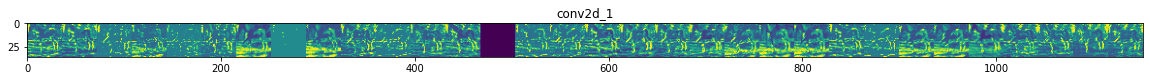

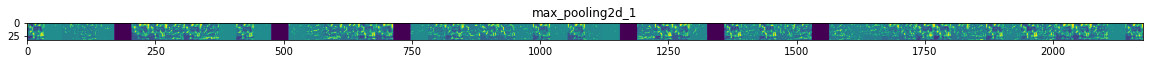

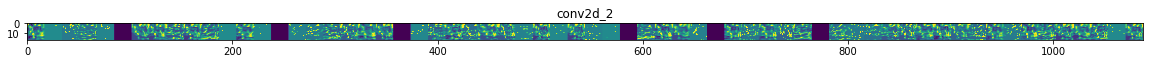

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

To visualize the intermediate steps and otputs. We start with a `for` that loops over the output of every layer and we store it in the `sucessive_outputs` variable. We skip the first layer [1:] 

In [ ]:
model.layers

The output of every layer is a `KerasTensor` which is a sort of array:

In [ ]:
model.layers[1].output

<KerasTensor: shape=(None, 74, 74, 16) dtype=float32 (created by layer 'max_pooling2d')>

In [ ]:
successive_outputs

[<KerasTensor: shape=(None, 74, 74, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 72, 72, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 36, 36, 32) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 34, 34, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 17, 17, 64) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 18496) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>]

We create a visualization model:


```
Model(img_input, successive_outputs)
```



Then we create two arrays, one for each category containing the names (with path) of every image in the directories:

In [ ]:
horse_img_files[1:10]

['/tmp/horse-or-human/horses/horse43-1.png',
 '/tmp/horse-or-human/horses/horse27-3.png',
 '/tmp/horse-or-human/horses/horse40-1.png',
 '/tmp/horse-or-human/horses/horse25-1.png',
 '/tmp/horse-or-human/horses/horse30-5.png',
 '/tmp/horse-or-human/horses/horse16-2.png',
 '/tmp/horse-or-human/horses/horse12-5.png',
 '/tmp/horse-or-human/horses/horse33-5.png',
 '/tmp/horse-or-human/horses/horse21-7.png']

Then we convert the image to an array and reshape it. See that the argument of the `reshape()` function is the output shape you want to obtain, in this case our desire is *(1, 150, 150, 3)*


```
x = x.reshape(1,150,150,3)
```



The result of the `visualization_model.predict(x)` function is a list of lists, in this case with a len of 8 (same as the number of output layers). We zip them with the name of the layers

In [ ]:
len(successive_feature_maps), len(successive_outputs)

(8, 8)

In [ ]:
successive_feature_maps = visualization_model.predict(x)

ValueError: ignored

In [ ]:
for feature_map in successive_feature_maps:
  print(len(feature_map.shape))


4
4
4
4
4
2
2
2
